# Урок 6. Нейросети в обработке текста

Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твиттера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

In [1]:
max_words = 2000
max_len = 40
num_classes = 1

# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [2]:
import pandas as pd

df_train = pd.read_csv("twitter/train.csv")
df_test  = pd.read_csv("twitter/test.csv")

In [3]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
df_train, df_val = train_test_split(df_train, shuffle=True, test_size=0.2)

In [7]:
display(df_train['label'].value_counts())
display(df_val['label'].value_counts())

0    23765
1     1804
Name: label, dtype: int64

0    5955
1     438
Name: label, dtype: int64

### Предобработка

In [8]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [9]:
sw = set(get_stop_words("en"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['tweet'] = df_train['tweet'].apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].apply(preprocess_text)

In [10]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [11]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [12]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [13]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [14]:
tokens_filtered_top[10:]

['life',
 'like',
 'today',
 'new',
 'now',
 'get',
 'positive',
 'thankful',
 'good',
 'people',
 'bihday',
 'cant',
 'one',
 'see',
 'can',
 'dont',
 'fathers',
 'smile',
 'want',
 'work',
 'go',
 'take',
 'healthy',
 'weekend',
 'fun',
 'got',
 'make',
 'bull',
 'beautiful',
 'family',
 'us',
 'great',
 'best',
 'need',
 'friday',
 'way',
 'summer',
 'friends',
 '2',
 'days',
 'really',
 'going',
 'wait',
 'first',
 'music',
 'back',
 'morning',
 'know',
 'tomorrow',
 'world',
 'think',
 'never',
 'week',
 'cute',
 'fathersday',
 'sad',
 'feel',
 'blog',
 'orlando',
 'affirmation',
 'happiness',
 'model',
 'right',
 'home',
 'well',
 'sunday',
 'trump',
 'always',
 'much',
 'next',
 'youre',
 'night',
 'girl',
 'finally',
 'last',
 'even',
 'things',
 'live',
 'iam',
 'come',
 'gold',
 'look',
 'ready',
 'amazing',
 'still',
 'thank',
 'find',
 'silver',
 'thanks',
 'year',
 'altwaystoheal',
 'tonight',
 'makes',
 'many',
 'free',
 'looking',
 'little',
 'follow',
 'via',
 'pay',
 '

In [15]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [16]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [17]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]], dtype=np.int32)

In [18]:
x_train.shape

(25569, 40)

In [19]:
x_train[1]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   1, 603,  12, 386,
        87])

In [20]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True


In [21]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output

In [22]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = target
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [23]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        data = data.cuda()
        target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(2000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 305409
Train epoch 1/10
Step 0: loss=1.15614652633667
Train epoch 2/10
Step 0: loss=0.13091212511062622
Train epoch 3/10
Step 0: loss=0.07139918208122253
Train epoch 4/10
Step 0: loss=0.04512270539999008
Train epoch 5/10
Step 0: loss=0.028039950877428055
Train epoch 6/10
Step 0: loss=0.01662302017211914
Train epoch 7/10
Step 0: loss=0.010215788148343563
Train epoch 8/10
Step 0: loss=0.010465106926858425
Train epoch 9/10
Step 0: loss=0.008139705285429955
Train epoch 10/10
Step 0: loss=0.003394340630620718


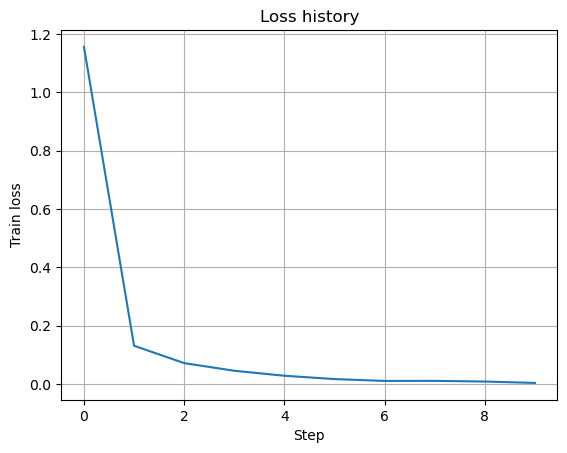

In [24]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);